# Setup and Imports

In [2]:
import prepare_MRI_images as pmi
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import adam_v2, rmsprop_v2
from keras.optimizers import gradient_descent_v2
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import ParameterSampler
from scipy.stats import reciprocal

from keras.applications import vgg16, xception, ResNet50V2, InceptionResNetV2, EfficientNetB7

# Get the Data

In [20]:
no_tumor_path = 'brain-mri-images-for-brain-tumor-detection/no'
tumor_path = 'brain-mri-images-for-brain-tumor-detection/yes'
width = 256
height = 256
color = 'RGB'
num_no_tumors = len(os.listdir(no_tumor_path))
num_tumors = len(os.listdir(tumor_path))

X, y = pmi.clean_MRI_scans(no_tumor_path, tumor_path, width, height, color, num_no_tumors, num_tumors)

In [21]:
print(X.shape)
print(y.shape)

(253, 256, 256, 3)
(253,)


# Split the Data into Training and Test Sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state=42, stratify=y_train) 

In [23]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(151, 256, 256, 3)
(51, 256, 256, 3)
(51, 256, 256, 3)
(151,)
(51,)
(51,)


In [25]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
)
datagen.fit(X_train)

# Transfer Learning

## VGG16 Architecture

In [9]:
vgg16_model = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3), pooling = 'avg')

In [10]:
for layer in vgg16_model.layers[:-5]:
    layer.trainable = False

In [26]:
last_output = vgg16_model.output

x = Dense(2, activation = 'softmax')(last_output)

new_vgg16_model = Model(inputs = vgg16_model.input, outputs = x)

new_vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [27]:
new_vgg16_model.compile(optimizer = adam_v2.Adam(learning_rate = 0.0001), 
                        loss = 'sparse_categorical_crossentropy', metrics = ["accuracy"])

In [29]:
early = EarlyStopping(monitor = 'val_loss', patience = 5)
vgg_history = new_vgg16_model.fit(datagen.flow(X_train, y_train, batch_size = 32),
                       epochs = 100, verbose = 0, validation_data = (X_val, y_val),
                       callbacks = [early])

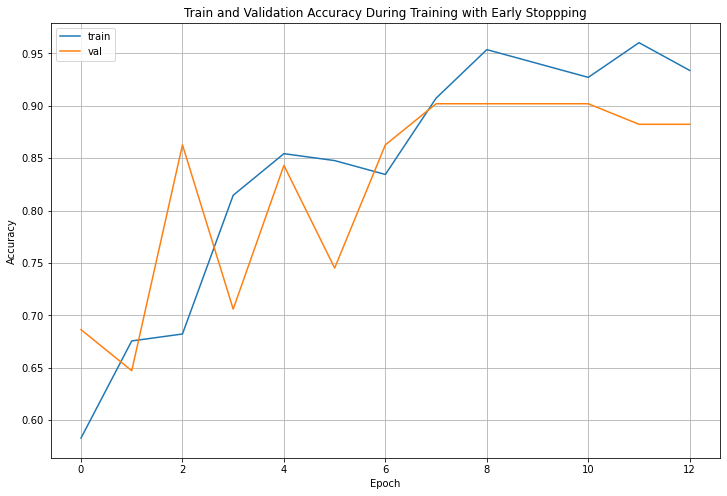

In [31]:
plt.figure(figsize = (12,8))
plt.plot(vgg_history.history['accuracy'], label='train')
plt.plot(vgg_history.history['val_accuracy'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy During Training with Early Stoppping")
plt.legend()
plt.show()

## Xception Architecture

In [32]:
xception_model = xception.Xception(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3), pooling = 'avg')

In [33]:
for layer in xception_model.layers[:-5]:
    layer.trainable = False

In [35]:
last_output = xception_model.output

x = Dense(2, activation = 'softmax')(last_output)

new_xception_model = Model(inputs = xception_model.input, outputs = x)


In [36]:
new_xception_model.compile(optimizer = adam_v2.Adam(learning_rate = 0.0001), 
                        loss = 'sparse_categorical_crossentropy', metrics = ["accuracy"])

In [37]:
early = EarlyStopping(monitor = 'val_loss', patience = 5)
xception_history = new_xception_model.fit(datagen.flow(X_train, y_train, batch_size = 32),
                       epochs = 100, verbose = 0, validation_data = (X_val, y_val),
                       callbacks = [early])

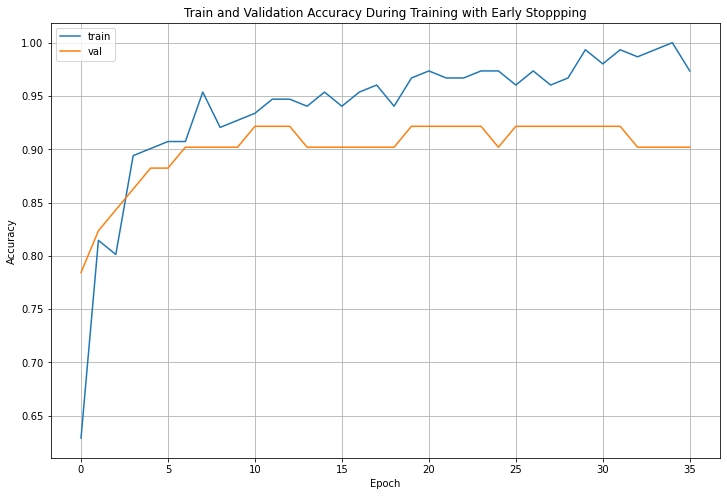

In [38]:
plt.figure(figsize = (12,8))
plt.plot(xception_history.history['accuracy'], label='train')
plt.plot(xception_history.history['val_accuracy'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy During Training with Early Stoppping")
plt.legend()
plt.show()

## ResNet Architecture

In [ ]:
resnet_model = ResNet50V2.ResNet50V2(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3), pooling = 'avg')

In [ ]:
for layer in resnet_model.layers[:-5]:
    layer.trainable = False

In [ ]:
last_output = resnet_model.output

x = Dense(2, activation = 'softmax')(last_output)

new_resnet_model = Model(inputs = resnet_model.input, outputs = x)

new_resnet_model.summary()

In [ ]:
new_resnet_model.compile(optimizer = adam_v2.Adam(learning_rate = 0.0001), 
                        loss = 'sparse_categorical_crossentropy', metrics = ["accuracy"])

In [ ]:
early = EarlyStopping(monitor = 'val_loss', patience = 5)
resnet_history = new_resnet_model.fit(datagen.flow(X_train, y_train, batch_size = 32),
                       epochs = 100, verbose = 0, validation_data = (X_val, y_val),
                       callbacks = [early])

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(resnet_history.history['accuracy'], label='train')
plt.plot(resnet_history.history['val_accuracy'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy During Training with Early Stoppping")
plt.legend()
plt.show()

## Inception ResNet Architecture

In [ ]:
inception_res_model = InceptionResNetV2.InceptionResNetV2(weights = 'imagenet', include_top = False, 
                                                     input_shape = (256, 256, 3), pooling = 'avg')

In [ ]:
for layer in inception_res_model.layers[:-5]:
    layer.trainable = False

In [ ]:
last_output = inception_res_model.output

x = Dense(2, activation = 'softmax')(last_output)

new_inception_res_model = Model(inputs = inception_res_model.input, outputs = x)

new_inception_res_model.summary()

In [ ]:
new_inception_res_model.compile(optimizer = adam_v2.Adam(learning_rate = 0.0001), 
                        loss = 'sparse_categorical_crossentropy', metrics = ["accuracy"])

In [ ]:
early = EarlyStopping(monitor = 'val_loss', patience = 5)
inception_res_history = new_inception_res_model.fit(datagen.flow(X_train, y_train, batch_size = 32),
                       epochs = 100, verbose = 0, validation_data = (X_val, y_val),
                       callbacks = [early])

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(inception_res_history.history['accuracy'], label='train')
plt.plot(inception_res_history.history['val_accuracy'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy During Training with Early Stoppping")
plt.legend()
plt.show()

## EfficientNet Architecture

In [ ]:
efficientnet_model = EfficientNetB7.EfficientNetB7(weights = 'imagenet', include_top = False, 
                                               input_shape = (256, 256, 3), pooling = 'avg')

In [ ]:
for layer in efficientnet_model.layers[:-5]:
    layer.trainable = False

In [ ]:
last_output = efficientnet_model.output

x = Dense(2, activation = 'softmax')(last_output)

new_efficientnet_model = Model(inputs = efficientnet_model.input, outputs = x)

new_efficientnet_model.summary()

In [ ]:
new_efficientnet_model.compile(optimizer = adam_v2.Adam(learning_rate = 0.0001), 
                        loss = 'sparse_categorical_crossentropy', metrics = ["accuracy"])

In [ ]:
early = EarlyStopping(monitor = 'val_loss', patience = 5)
efficientnet_history = new_efficientnet_model.fit(datagen.flow(X_train, y_train, batch_size = 32),
                       epochs = 100, verbose = 0, validation_data = (X_val, y_val),
                       callbacks = [early])

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(efficientnet_history.history['accuracy'], label='train')
plt.plot(efficientnet_history.history['val_accuracy'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy During Training with Early Stoppping")
plt.legend()
plt.show()

# Test Results